In [1]:
import polynomial_matching as pm
import cv2
import numpy as np
import matplotlib.pyplot as plt
import rawpy
import pandas as pd

## Read images

In [2]:
raw_images = []
for i in range(1,6):
    raw = cv2.imread('data/image/Canon1DsMkIII_000{}.tiff'.format(i), cv2.IMREAD_UNCHANGED)
    raw_images.append(cv2.demosaicing(raw, cv2.COLOR_BAYER_BG2BGR))

In [3]:
def normIm(image, darkness, saturation):
    '''Normalize the image to [0,1]'''
    return (image-darkness)/(saturation-darkness)

In [4]:
darkness_level = 1024.
saturation_level = 15279.

In [5]:
norm_images = []
for im in raw_images:
    norm_images.append(normIm(im, 1024., 15279))

In [6]:
def gammaCorrection(image, gamma=2.2):
    '''Convert linear RGB to sRGB with gammaCorrection'''
    invgamma = 1 / gamma
    return (np.power(image, invgamma)*255).astype(np.uint8)

In [7]:
sRGB_images = []
for im in norm_images:
    sRGB_images.append(cv2.cvtColor(gammaCorrection(im),cv2.COLOR_BGR2RGB))

C:\Users\HP\AppData\Local\Temp/ipykernel_25708/99706111.py:4: RuntimeWarning: invalid value encountered in power
  return (np.power(image, invgamma)*255).astype(np.uint8)


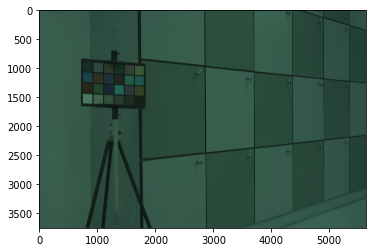

In [8]:
plt.imshow(cv2.cvtColor(sRGB_images[0],cv2.COLOR_BGR2RGB))

## Read patch color

In [9]:
patches = []
for i in range(1, 6):
    rawpatch = pd.read_csv('data/checker/Canon1DsMkIII_000{}_color.txt'.format(i), names=['1','2','3']).to_numpy() # access to the RAW image
    patches.append(gammaCorrection(normIm(rawpatch,darkness_level,saturation_level)))
    
print(patches[0])

[[ 96 120  78]
 [ 77  97  64]
 [ 62  79  51]
 [ 47  60  39]
 [ 35  45  29]
 [ 24  31  19]
 [ 25  38  41]
 [ 44  69  32]
 [ 54  42  22]
 [ 87 100  35]
 [ 61  55  45]
 [ 37  64  53]
 [ 74  67  26]
 [ 34  48  48]
 [ 63  51  32]
 [ 33  38  31]
 [ 67  90  36]
 [ 79  85  29]
 [ 41  44  25]
 [ 68  72  43]
 [ 38  53  41]
 [ 34  46  21]
 [ 51  66  52]
 [ 58  90  57]]


In [10]:
print(patches[0][:,0])

[96 77 62 47 35 24 25 44 54 87 61 37 74 34 63 33 67 79 41 68 38 34 51 58]


In [12]:
stdmatch = []
stdimages = []
for i in range(0, len(patches)):
    stdmatch.append(pm.polyCoeff(patches[i], pm.ColorChecker2005_sRGB))
    stdmatch[-1].to_npy('data/Canon1DsMkIII_000{}.npy'.format(i))
    stdimages.append(stdmatch[-1].transform(sRGB_images[i]))

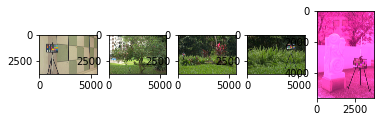

In [14]:
fig, ax = plt.subplots(1, 5)

ax[0].imshow(stdimages[0])
ax[1].imshow(stdimages[1])
ax[2].imshow(stdimages[2])
ax[3].imshow(stdimages[3])
ax[4].imshow(stdimages[4])
plt.show()

In [18]:
cv2.imwrite('error_image.png', cv2.cvtColor(stdimages[4], cv2.COLOR_RGB2BGR))

True

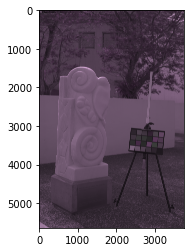

In [19]:
plt.imshow(cv2.cvtColor(sRGB_images[4],cv2.COLOR_BGR2RGB))

In [22]:
uniquematch=[]
uniqueimages=[]
for i in range(0, len(patches)-1):
    uniquematch.append(pm.polyCoeff(pm.ColorChecker2005_sRGB, patches[i]))
    uniquematch[-1].to_npy('data/Canon1DsMkIII_000{}.npy'.format(i))
    uniqueimages.append(uniquematch[-1].transform(stdimages[0]))

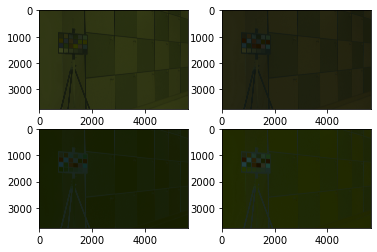

In [23]:
fig, ax = plt.subplots(2, 2)

ax[0, 0].imshow(uniqueimages[0])
ax[0, 1].imshow(uniqueimages[1])
ax[1, 0].imshow(uniqueimages[2])
ax[1, 1].imshow(uniqueimages[3])
plt.show()